In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import skimage
from skimage.transform import resize
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import model_from_json

In [2]:
train_folder = 'C:/Users/subha/Downloads/ASL/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
1,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
2,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
3,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
4,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
...,...,...
86995,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
86996,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
86997,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
86998,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...


In [3]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [4]:
img_width, img_height = 75, 75
batch_size = 16
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
    )

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [5]:
base_model = InceptionV3(input_shape=(75,75,3), weights='imagenet', include_top=False)
base_model.trainable = False

87924736/87910968 [==============================] - 2s 0us/step


In [6]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
#dense_layer_2 = layers.Dense(512, activation='relu')
#dropout_layer_2 = layers.Dropout(0.5)
prediction_layer = layers.Dense(29, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    #dense_layer_2,
    #dropout_layer_2,
    prediction_layer
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                14877     
Total params: 22,866,749
Trainable params: 1,063,965
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
classes = 29
epochs = 10
learning_rate = 0.0001

adam = Adam(lr=learning_rate)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True)

Epoch 1/10


C:\Users\subha\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


3915/3915 [==============================] - 114s 26ms/step - loss: 1.3583 - accuracy: 0.6222 - val_loss: 0.5464 - val_accuracy: 0.8675
Epoch 2/10
3915/3915 [==============================] - 101s 26ms/step - loss: 0.5311 - accuracy: 0.8485 - val_loss: 0.3074 - val_accuracy: 0.9277
Epoch 3/10
3915/3915 [==============================] - 100s 26ms/step - loss: 0.3351 - accuracy: 0.9049 - val_loss: 0.2070 - val_accuracy: 0.9518
Epoch 4/10
3915/3915 [==============================] - 100s 26ms/step - loss: 0.2371 - accuracy: 0.9334 - val_loss: 0.1485 - val_accuracy: 0.9657
Epoch 5/10
3915/3915 [==============================] - 100s 26ms/step - loss: 0.1807 - accuracy: 0.9497 - val_loss: 0.1173 - val_accuracy: 0.9718
Epoch 6/10
3915/3915 [==============================] - 100s 26ms/step - loss: 0.1408 - accuracy: 0.9619 - val_loss: 0.0937 - val_accuracy: 0.9785
Epoch 7/10
3915/3915 [==============================] - 100s 26ms/step - loss: 0.1116 - accuracy: 0.9698 - val_loss: 0.0825 - val

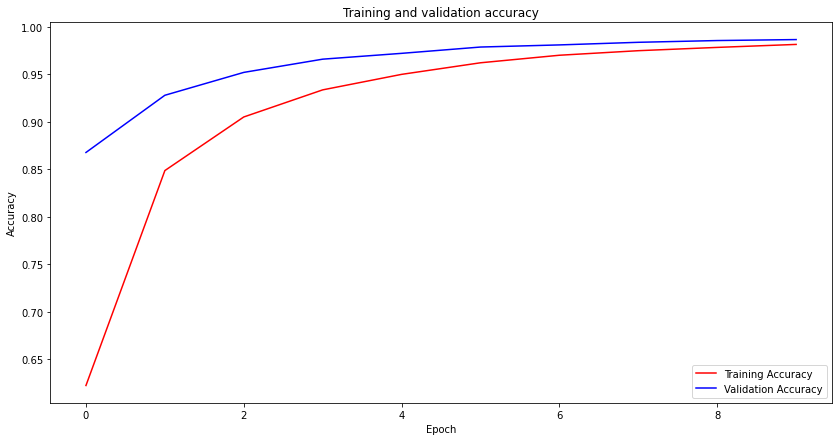

In [10]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

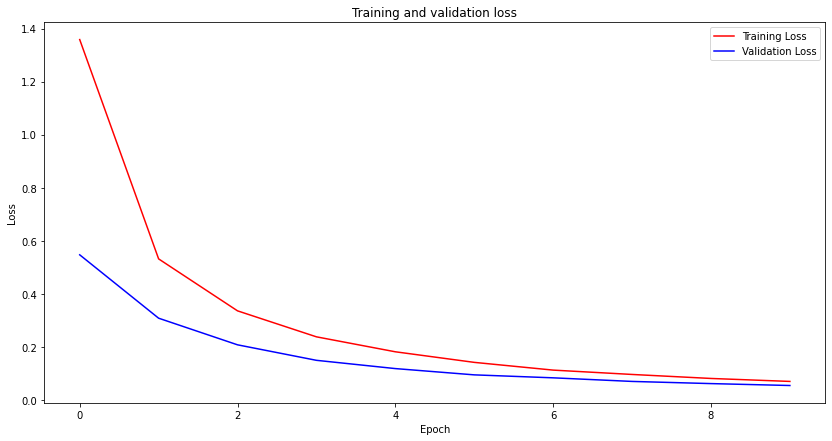

In [11]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [12]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

544/544 [==============================] - 9s 14ms/step
              precision    recall  f1-score   support

           A       0.98      0.98      0.98       300
           B       0.99      0.98      0.99       300
           C       1.00      1.00      1.00       300
           D       0.99      1.00      1.00       300
           E       0.98      0.98      0.98       300
           F       0.99      0.99      0.99       300
           G       0.99      0.99      0.99       300
           H       0.99      1.00      0.99       300
           I       0.99      0.98      0.99       300
           J       1.00      1.00      1.00       300
           K       0.98      0.98      0.98       300
           L       1.00      1.00      1.00       300
           M       0.99      0.98      0.98       300
           N       0.98      0.99      0.99       300
           O       1.00      0.99      0.99       300
           P       1.00      0.99      0.99       300
           Q       1.00  

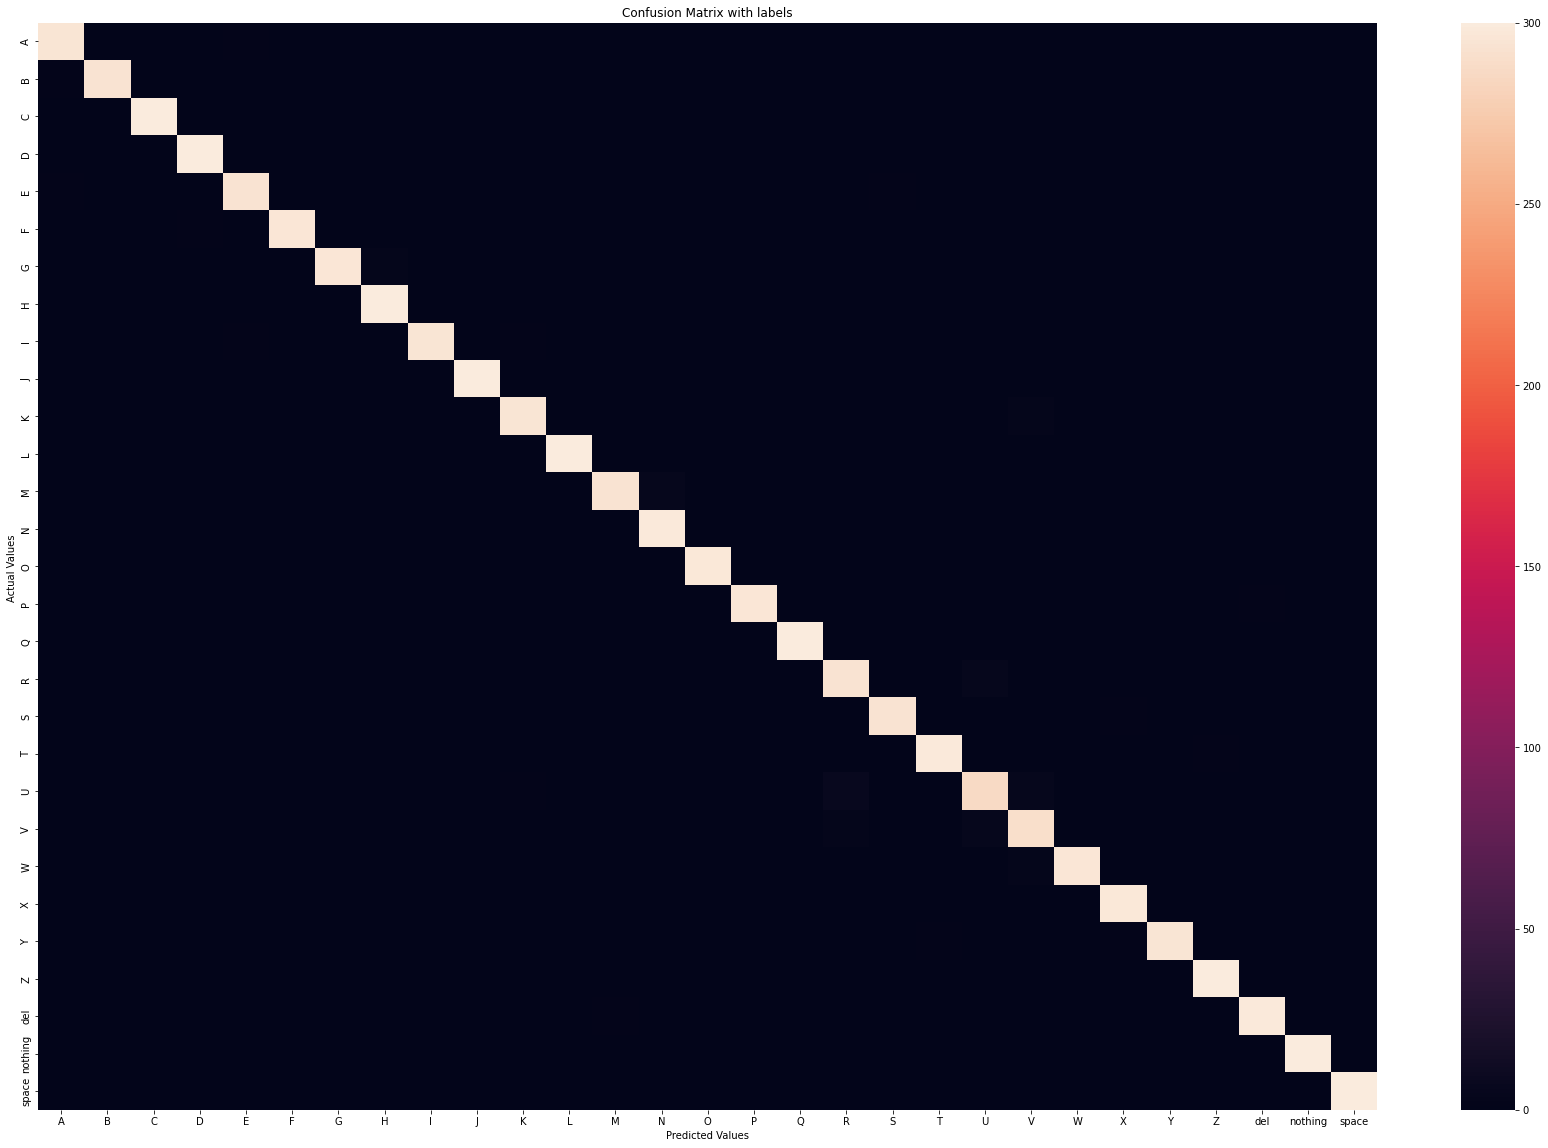

In [13]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [14]:
model.save('signInceptionV3_3.h5')

In [15]:
confusion = metrics.confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[295   0   0   0   2   0   0   0   0   0   0   0   1   0   0   0   0   0
    0   1   1   0   0   0   0   0   0   0   0]
 [  2 294   0   0   1   0   0   1   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   1   0   0   0   0   0   0]
 [  0   0 299   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0 293   0   0   0   1   0   0   0   0   0   0   0   0   0
    2   0   1   0   0   0   0   1   0   0   0]
 [  0   0   0   2   0 296   0   0   0   0   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   0   0   0   0   1]
 [  0   1   0   0   0   0 296   3   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 300   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 

<AxesSubplot:>

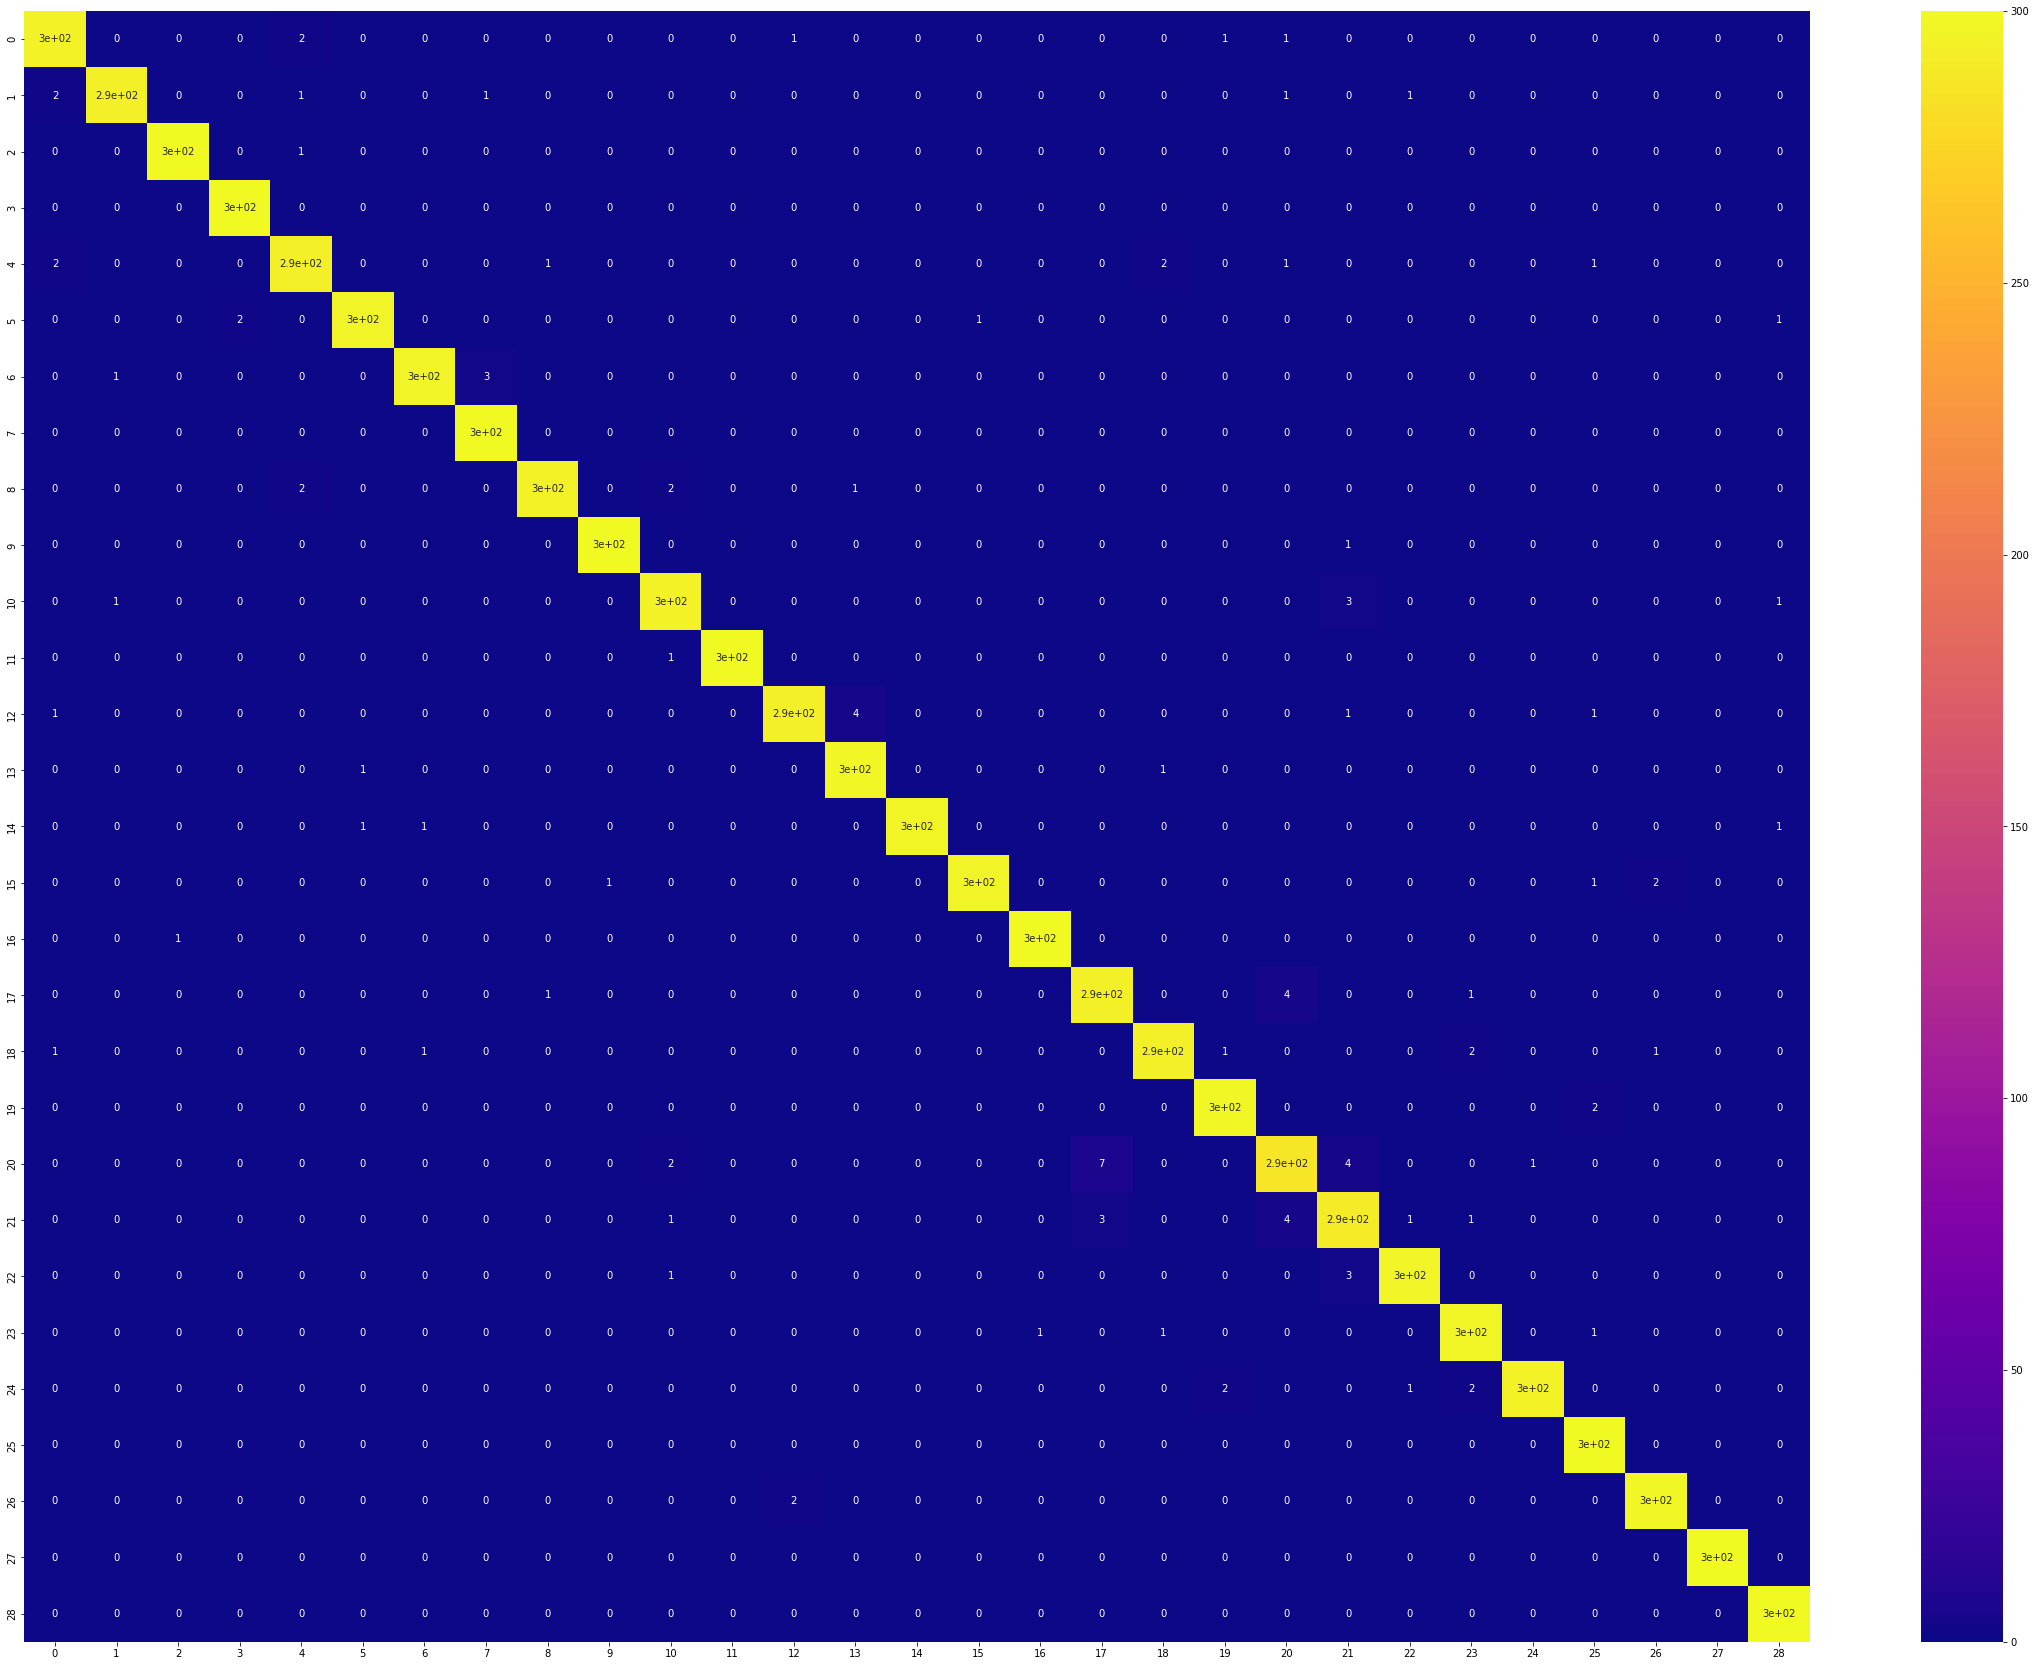

In [16]:
plt.figure(figsize=(40, 30))
sns.heatmap(confusion, cmap="plasma", annot=True)